<div style="float:right; padding-top: 15px; padding-right: 15px">
    <div>
        <a href="https://whiteboxml.com">
            <img src="https://whiteboxml.com/static/img/logo/black_bg_white.svg" width="250">
        </a>
    </div>
</div>

# NLP Gamereactor clustering

## 0. python imports

In [15]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy

from hdbscan import HDBSCAN
from spacy.lang.es.stop_words import STOP_WORDS
from spacy.lang.es import Spanish
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.utils import shuffle
from umap import UMAP

with warnings.catch_warnings():
    warnings.simplefilter('ignore')

## 1. data loading

list of titles of best 100 films ever made...

In [2]:
gamereactor_df = pd.read_csv('../data/gamereactor_data.csv')

gamereactor_df[:3]

,title,author,review,url
0,Kingdoms of Amalur: Re-Reckoning,Roy Woodhouse,Sé que no todo el mundo lo recibió igual de bi...,https://www.gamereactor.es/kingdoms-of-amalur-...
1,Tennis World Tour 2 - Iguales,Daniel Andersen,Habían pasado muchos años sin que los fans de ...,https://www.gamereactor.es/tennis-world-tour-2...
2,Hades,Ricardo C. Esteves,El periplo por un limbo llamado acceso anticip...,https://www.gamereactor.es/hades-analisis/?sid...


In [3]:
meristation_df = pd.read_csv('../data/meristation_data.csv')

meristation_df[:3]

,title,author,review,url
0,Análisis Bounty Battle; el título de lucha de ...,NaN,Después del anuncio de su retraso indefinido e...,https://as.com/meristation/2020/09/22/analisis...
1,"eFootball PES 2021, análisis. Rueda el balón, ...",NaN,La temporada futbolística acabó de manera atíp...,https://as.com/meristation/2020/09/22/analisis...
2,"Milky Way Prince: The Vampire Prince, análisis...",NaN,El amor es uno de los temas universales que pe...,https://as.com/meristation/2020/09/21/analisis...


In [4]:
double = [gamereactor_df, meristation_df]

gr_meri_df = pd.concat(double)

In [16]:
gr_meri_df = shuffle(gr_meri_df)
gr_meri_df.reset_index(drop=True, inplace=True)

In [18]:
gr_meri_df.head()

,title,author,review,url
0,"Project Cars 3, análisis PS4",NaN,Los momentos más dolorosos de la vida de todo ...,https://as.com/meristation/2020/08/26/analisis...
1,"Spiritfarer, análisis",NaN,"Cuando Chihiro llega, acompañada de sus padres...",https://as.com/meristation/2020/09/01/analisis...
2,Peaky Blinders: Mastermind - La precuela,Ricardo C. Esteves,"Siendo fans de Peaky Blinders, un juego de ave...",https://www.gamereactor.es/peaky-blinders-mast...
3,"Wasteland 3, análisis. inXile da el salto de c...",NaN,El rol isométrico se resiste a desaparecer. So...,https://as.com/meristation/2020/08/29/analisis...
4,Fall Guys: Ultimate Knockout,Mike Holmes,Fall Guys: Ultimate Knockout llegó el otro día...,https://www.gamereactor.es/fall-guys-ultimate-...


In [19]:
synopses = gr_meri_df['review']

In [23]:
synopses[:3]

0    Los momentos más dolorosos de la vida de todo ...
1    Cuando Chihiro llega, acompañada de sus padres...
2    Siendo fans de Peaky Blinders, un juego de ave...
Name: review, dtype: object

## 2. data processing

In [24]:
parser = spacy.load("es_core_news_md")
parser.Defaults.stop_words.add("y")

In [25]:
import re

def spacy_tokenizer(sentence):

    tokens = parser(sentence)
    
    filtered_tokens = []
    for word in tokens:
        lemma = word.lemma_.lower().strip()
        
        if lemma not in STOP_WORDS and re.search('^[a-zA-Z]+$', lemma):
            filtered_tokens.append(lemma)

    return filtered_tokens

In [26]:
spacy_tokenizer(synopses[0])[:15]

['doloroso',
 'vida',
 'humanar',
 'deber',
 'forzosamente',
 'a',
 'querer',
 'familiar',
 'amigar',
 'o',
 'animal',
 'tratar',
 'experiencia',
 'dejar',
 'muesca']

## 3. term-frequency matrix

In [27]:
tfidf_vectorizer = TfidfVectorizer(min_df=0.15, tokenizer=spacy_tokenizer)
tfidf_matrix = tfidf_vectorizer.fit_transform(synopses)
tfidf_matrix.shape

(95, 430)

In [28]:
tfidf_matrix.todense()

matrix([[0.49987139, 0.03101157, 0.        , ..., 0.        , 0.        ,
         0.02111442],
        [0.40476972, 0.11894944, 0.04161523, ..., 0.04913162, 0.        ,
         0.        ],
        [0.57194159, 0.        , 0.22344961, ..., 0.05276165, 0.        ,
         0.        ],
        ...,
        [0.5213398 , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.48563693, 0.08473634, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.31933049, 0.        , 0.        , ..., 0.09205706, 0.        ,
         0.        ]])

In [29]:
terms = tfidf_vectorizer.get_feature_names()

terms[:15]

['a',
 'abandonar',
 'abrir',
 'acabar',
 'accionar',
 'acercar',
 'activar',
 'actual',
 'adaptar',
 'afectar',
 'agradecer',
 'alcanzar',
 'alto',
 'altura',
 'amante']

In [30]:
dist = 1 - cosine_similarity(tfidf_matrix)

dist

array([[1.11022302e-16, 4.57192903e-01, 5.32053148e-01, ...,
        4.45792996e-01, 4.65004488e-01, 5.09654335e-01],
       [4.57192903e-01, 0.00000000e+00, 5.37293051e-01, ...,
        5.02257256e-01, 5.24672233e-01, 5.45852469e-01],
       [5.32053148e-01, 5.37293051e-01, 0.00000000e+00, ...,
        5.39784726e-01, 5.45018937e-01, 6.20988730e-01],
       ...,
       [4.45792996e-01, 5.02257256e-01, 5.39784726e-01, ...,
        0.00000000e+00, 4.78881386e-01, 5.02280506e-01],
       [4.65004488e-01, 5.24672233e-01, 5.45018937e-01, ...,
        4.78881386e-01, 0.00000000e+00, 6.31258955e-01],
       [5.09654335e-01, 5.45852469e-01, 6.20988730e-01, ...,
        5.02280506e-01, 6.31258955e-01, 0.00000000e+00]])

## 4. text clustering

In [31]:
umap = UMAP(n_neighbors=3, random_state=42)
embedding = umap.fit_transform(dist)

In [32]:
embedding[:5,:]

array([[ 8.98025   ,  4.258869  ],
       [11.800543  ,  2.9827614 ],
       [ 8.532794  , -0.36445206],
       [12.138266  ,  0.9283597 ],
       [ 8.358547  ,  4.5490427 ]], dtype=float32)

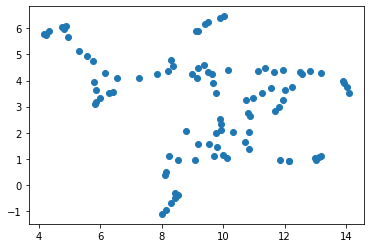

In [33]:
plt.scatter(embedding[:,0], embedding[:,1]);

### Con HDBSCAN

In [34]:
hdbscan = HDBSCAN(min_cluster_size=7)
clustering = hdbscan.fit_predict(embedding)
np.unique(clustering)

array([-1,  0,  1])

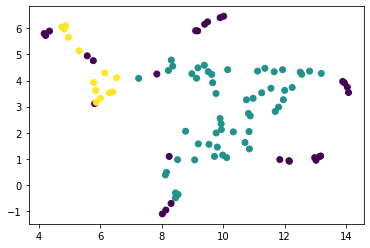

In [35]:
plt.scatter(embedding[:,0], embedding[:,1], c=clustering);

In [43]:
games = pd.DataFrame({'cluster': clustering, 'title': gr_meri_df['title'], 'synopsis': synopses, 'web': gr_meri_df['url']})

In [44]:
games.head(8)

,cluster,title,synopsis,web
0,0,"Project Cars 3, análisis PS4",Los momentos más dolorosos de la vida de todo ...,https://as.com/meristation/2020/08/26/analisis...
1,0,"Spiritfarer, análisis","Cuando Chihiro llega, acompañada de sus padres...",https://as.com/meristation/2020/09/01/analisis...
2,0,Peaky Blinders: Mastermind - La precuela,"Siendo fans de Peaky Blinders, un juego de ave...",https://www.gamereactor.es/peaky-blinders-mast...
3,-1,"Wasteland 3, análisis. inXile da el salto de c...",El rol isométrico se resiste a desaparecer. So...,https://as.com/meristation/2020/08/29/analisis...
4,0,Fall Guys: Ultimate Knockout,Fall Guys: Ultimate Knockout llegó el otro día...,https://www.gamereactor.es/fall-guys-ultimate-...
5,0,Tony Hawk's Pro Skater 1 + 2,Hay algunos juegos de los viejos tiempos de Pl...,https://www.gamereactor.es/tony-hawks-pro-skat...
6,1,Wasteland 3,Lo primero que se viene a la cabeza al pensar ...,https://www.gamereactor.es/wasteland-3-analisi...
7,0,Tell Me Why - Juego Completo,Escribir un relato de peso e impacto y ser cap...,https://www.gamereactor.es/tell-me-why-juego-c...


In [45]:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=terms)
tfidf_df.head()

,a,abandonar,abrir,acabar,accionar,acercar,activar,actual,adaptar,afectar,...,viajar,vida,videojuego,visitar,visual,vivir,volver,voz,xbox,zona
0,0.499871,0.031012,0.000000,0.000000,0.000000,0.029703,0.000000,0.0,0.000000,0.031012,...,0.000000,0.040060,0.107513,0.000000,0.021114,0.0,0.000000,0.000000,0.0,0.021114
1,0.404770,0.118949,0.041615,0.066340,0.052690,0.056966,0.000000,0.0,0.000000,0.000000,...,0.055814,0.115241,0.034365,0.059475,0.040494,0.0,0.000000,0.049132,0.0,0.000000
2,0.571942,0.000000,0.223450,0.035621,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.168151,0.052762,0.0,0.000000
3,0.683752,0.072033,0.000000,0.020087,0.095724,0.068994,0.032508,0.0,0.036016,0.036016,...,0.000000,0.023262,0.020811,0.036016,0.024522,0.0,0.000000,0.059506,0.0,0.049044
4,0.602266,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.064669,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.034051,0.000000,0.0,0.044030


In [46]:
def get_df_from_cluster(cluster):
    return tfidf_df[clustering==cluster]

get_df_from_cluster(0)

,a,abandonar,abrir,acabar,accionar,acercar,activar,actual,adaptar,afectar,...,viajar,vida,videojuego,visitar,visual,vivir,volver,voz,xbox,zona
0,0.499871,0.031012,0.000000,0.000000,0.000000,0.029703,0.000000,0.000000,0.000000,0.031012,...,0.000000,0.040060,0.107513,0.000000,0.021114,0.000000,0.000000,0.000000,0.000000,0.021114
1,0.404770,0.118949,0.041615,0.066340,0.052690,0.056966,0.000000,0.000000,0.000000,0.000000,...,0.055814,0.115241,0.034365,0.059475,0.040494,0.000000,0.000000,0.049132,0.000000,0.000000
2,0.571942,0.000000,0.223450,0.035621,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.168151,0.052762,0.000000,0.000000
4,0.602266,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.064669,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034051,0.000000,0.000000,0.044030
5,0.471543,0.000000,0.054184,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.150046,0.044744,0.000000,0.000000,0.000000,0.122324,0.063970,0.000000,0.000000
7,0.550220,0.061443,0.000000,0.034268,0.000000,0.058851,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.079370,0.035502,0.000000,0.041834,0.000000,0.064706,0.050758,0.046887,0.041834
10,0.441349,0.077009,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.077009,0.000000,...,0.000000,0.000000,0.044496,0.000000,0.000000,0.056216,0.000000,0.000000,0.058765,0.000000
12,0.412880,0.000000,0.000000,0.000000,0.000000,0.073602,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.049632,0.044401,0.000000,0.052320,0.000000,0.000000,0.063480,0.000000,0.000000
14,0.502205,0.000000,0.078482,0.031278,0.049684,0.000000,0.151856,0.000000,0.000000,0.000000,...,0.000000,0.036222,0.064809,0.056081,0.000000,0.000000,0.029530,0.000000,0.042795,0.000000
16,0.593781,0.031277,0.000000,0.017444,0.000000,0.000000,0.000000,0.062555,0.093832,0.000000,...,0.000000,0.000000,0.108434,0.000000,0.000000,0.022832,0.032938,0.000000,0.000000,0.021295


In [47]:
top_words_cluster = get_df_from_cluster(0).T.sum(axis=1).sort_values(ascending=False)
top_words_cluster.head()

a        27.391197
parir    12.093259
comer     8.713420
jugar     8.186218
o         6.804654
dtype: float64

In [51]:
games[games['cluster'] == -1].title

3     Wasteland 3, análisis. inXile da el salto de c...
8                      A Total War Saga: Troy, análisis
9                     Hearthstone: Academia Scholomance
11    Vader Immortal: A Star Wars VR Series, análisi...
13              Turtle Beach Sealth 600 Gen 2, Análisis
15                         Carrion - Asquerosa venganza
17    Motorola Edge Plus, Análisis del smartphone di...
18                                        PGA Tour 2K21
21               Remnant: From the Ashes - Subject 2923
23                             WRC 9, análisis Xbox One
24                                          Hyper Scape
26    Predator Triton 900, Análisis de una portátil ...
29                           Fight Crab, análisis Steam
31                    eFootball PES 2021- Season Update
32    Marvel's Avengers, análisis. ¿El juego de supe...
34                                 Total War Saga: Troy
40                                   NBA 2K21, análisis
47    eFootball PES 2021, análisis. Rueda el bal

### Con DBSCAN

In [99]:
from sklearn.cluster import DBSCAN

dbscan_c = DBSCAN(eps=1,
                  min_samples=8).fit(embedding)

dbscan_c

DBSCAN(algorithm='auto', eps=1, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=8, n_jobs=None, p=None)

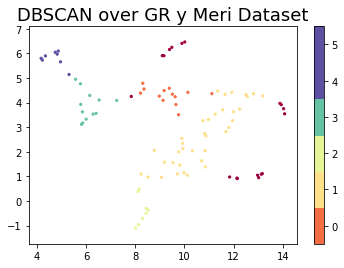

In [100]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=dbscan_c.labels_, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(len(np.unique(dbscan_c.labels_)) + 1) - 0.5).set_ticks(np.arange(len(np.unique(dbscan_c.labels_))))
plt.title('DBSCAN over GR y Meri Dataset', fontsize=18);

In [101]:
games = pd.DataFrame({'cluster': dbscan_c.labels_, 'title': gr_meri_df['title'], 'synopsis': synopses})

In [102]:
games.head(12)

,cluster,title,synopsis
0,0,"Project Cars 3, análisis PS4",Los momentos más dolorosos de la vida de todo ...
1,1,"Spiritfarer, análisis","Cuando Chihiro llega, acompañada de sus padres..."
2,2,Peaky Blinders: Mastermind - La precuela,"Siendo fans de Peaky Blinders, un juego de ave..."
3,-1,"Wasteland 3, análisis. inXile da el salto de c...",El rol isométrico se resiste a desaparecer. So...
4,0,Fall Guys: Ultimate Knockout,Fall Guys: Ultimate Knockout llegó el otro día...
5,1,Tony Hawk's Pro Skater 1 + 2,Hay algunos juegos de los viejos tiempos de Pl...
6,3,Wasteland 3,Lo primero que se viene a la cabeza al pensar ...
7,1,Tell Me Why - Juego Completo,Escribir un relato de peso e impacto y ser cap...
8,-1,"A Total War Saga: Troy, análisis",Lo de la saga Total War empieza a ser digno de...
9,3,Hearthstone: Academia Scholomance,El Año del Fénix de Hearthstone ha llegado a l...


In [103]:
games[games['cluster'] == -1].title

3     Wasteland 3, análisis. inXile da el salto de c...
8                      A Total War Saga: Troy, análisis
11    Vader Immortal: A Star Wars VR Series, análisi...
15                         Carrion - Asquerosa venganza
18                                        PGA Tour 2K21
23                             WRC 9, análisis Xbox One
24                                          Hyper Scape
31                    eFootball PES 2021- Season Update
32    Marvel's Avengers, análisis. ¿El juego de supe...
34                                 Total War Saga: Troy
40                                   NBA 2K21, análisis
47    eFootball PES 2021, análisis. Rueda el balón, ...
49       Ary and the Secret of Seasons, análisis Switch
50                                          Spiritfarer
52                                   Crusader Kings III
63    A Short Hike, Análisis. Un viaje con los ojos ...
73                                           Struggling
89    Fast & Furious: Crossroads, Ni Fu(rious) n

<div style="padding-top: 25px; float: right">
    <div>    
        <i>&nbsp;&nbsp;© Copyright by</i>
    </div>
    <div>
        <a href="https://whiteboxml.com">
            <img src="https://whiteboxml.com/static/img/logo/black_bg_white.svg" width="125">
        </a>
    </div>
</div>